#### This notebook attempts to fine-tune a ResNet50 pretrained model

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from joblib import dump
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

    Define Constants

In [2]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 40

    Data Directories

In [3]:
train_dir = '../datasets/train'
test_dir = '../datasets/test'

    Perform Data Augmentation for the Data

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

    Preprocess the test data in simple manner.

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

    Get training images in batches using train_data generator.

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  
)

Found 4173 images belonging to 2 classes.


    Get validation images in batches using validation generator.

In [7]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 1043 images belonging to 2 classes.


    One way to fight imbalance is to have class weights defined and add penalty for misclassfying minority class.
    - Generate samples, find weights and then use that to fit the model.

In [8]:
temp_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  
    shuffle=False  
)


Found 5216 images belonging to 2 classes.


    Compute the class weights

In [9]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(temp_generator.classes),
    y=temp_generator.classes
)

    Convert weights into dictionary

In [10]:
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

    Load the ResNet50 model, pretrained on ImageNet

In [11]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    Freeze the layers of the base model

In [12]:
for layer in base_model.layers:
    layer.trainable = False

    The model performs terribly bad, due to overfitting.
        - We must prevent it from overfitting. By using early stopping.

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To print messages when the callback takes an action
    restore_best_weights=True  # Optional: Restore model weights from the epoch with the best value of the monitored quantity
)

    Add new layers on top of ResNet

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) 

    Now train this model:

In [15]:
model = Model(inputs=base_model.input, outputs=predictions)

    Compile this model

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    Train this modified ResNet50

In [17]:
history = model.fit(train_generator, 
                    epochs=EPOCHS, 
                    validation_data=validation_generator, 
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping])


Epoch 1/40
131/131 [==============================] - 192s 1s/step - loss: 0.6617 - accuracy: 0.6274 - val_loss: 0.6729 - val_accuracy: 0.6453
Epoch 2/40
131/131 [==============================] - 180s 1s/step - loss: 0.5813 - accuracy: 0.7036 - val_loss: 0.6601 - val_accuracy: 0.6539
Epoch 3/40
131/131 [==============================] - 178s 1s/step - loss: 0.5096 - accuracy: 0.7630 - val_loss: 0.4740 - val_accuracy: 0.7498
Epoch 4/40
131/131 [==============================] - 182s 1s/step - loss: 0.4719 - accuracy: 0.7740 - val_loss: 0.4814 - val_accuracy: 0.7517
Epoch 5/40
131/131 [==============================] - 177s 1s/step - loss: 0.4517 - accuracy: 0.7783 - val_loss: 0.4815 - val_accuracy: 0.7526
Epoch 6/40
131/131 [==============================] - 181s 1s/step - loss: 0.4205 - accuracy: 0.7937 - val_loss: 0.4296 - val_accuracy: 0.7603
Epoch 7/40
131/131 [==============================] - 187s 1s/step - loss: 0.4391 - accuracy: 0.7824 - val_loss: 0.5400 - val_accuracy: 0.7210

    Training Acc. VS Validation Acc.

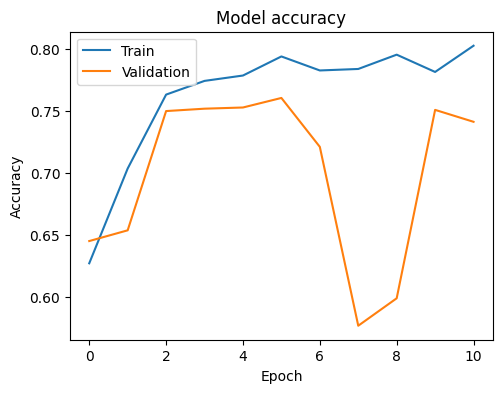

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

    Training Loss VS Validation Loss

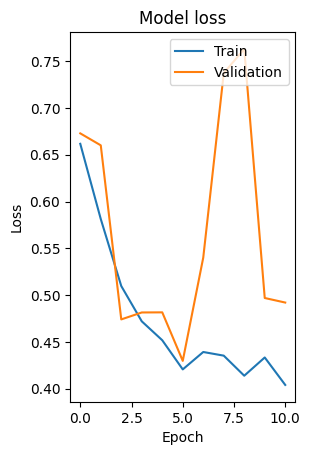

In [19]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

    Generate Test samples:

In [20]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  
)

Found 624 images belonging to 2 classes.


    Make Predictions

In [42]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.where(predictions > 0.5, 1, 0).reshape(-1)
true_classes = test_generator.classes

20/20 [==============================] - 19s 925ms/step


In [43]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.73      0.77      0.75       234
   PNEUMONIA       0.86      0.83      0.84       390

    accuracy                           0.80       624
   macro avg       0.79      0.80      0.79       624
weighted avg       0.81      0.80      0.81       624



    Let's plot the confusion matrix for the predicitons made:

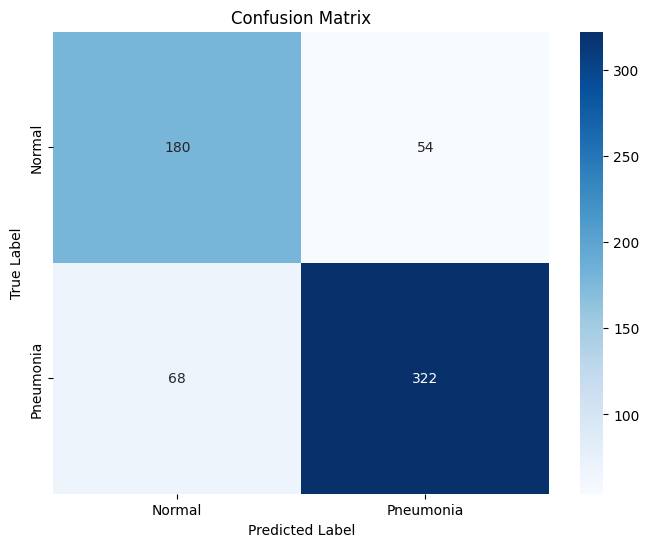

In [44]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

    Plot the ROC_curve

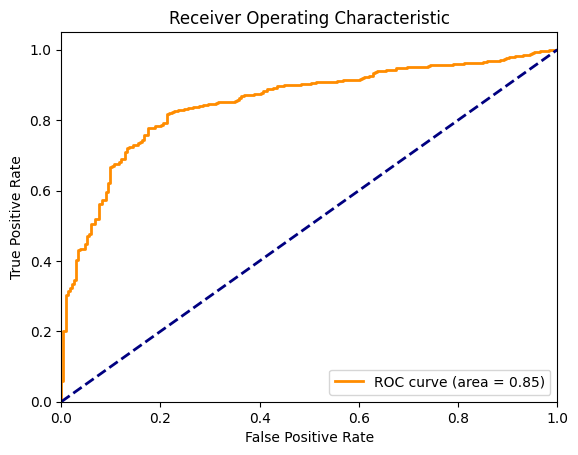

In [45]:
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

    Let's save the fitted CNN model for model persistence.

In [46]:
dump(model, "../Models/ResNet50-FineTuned.joblib")

['../Models/ResNet50-FineTuned.joblib']